# Abuse Subreddit Feature Analysis and LDA Topic Modeling
### Amie Kong
<br> This notebook includes experiments for the r/abuse subreddit using Linguistic Inquiry & Word Count (LIWC) Feature Analysis, VADER Sentiment Analysis, and Latent Dirichlet Allocation Topic Modeling.

#### Subreddit Extraction Resource:
https://www.jcchouinard.com/how-to-use-reddit-api-with-python/

#### VADER Extraction Resource: 
https://github.com/jrosen48/vader-sentiment-example

#### LDA Topic Modeling Resource: 
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

## Data Extraction & Exploratory Analysis

In [46]:
import pandas as pd
import re
from nltk.corpus import stopwords
import redditcleaner
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import gensim
import gensim.corpora as corpora
import nltk
from tqdm import tqdm
from gensim.models.coherencemodel import CoherenceModel
import warnings
from gensim import corpora, models
import pyLDAvis.gensim
import en_core_web_sm
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA
from pprint import pprint
import pickle

In [47]:
#midpandemic dataset
df_mid = pd.read_csv('reddit_data/liwc_abuse_midpandemic.csv')
#prepandemic dataset
df_pre = pd.read_csv('reddit_data/liwc_abuse_prepandemic.csv')
#control dataset
df_ctrl = pd.read_csv('reddit_data/liwc_control_abuse.csv')

In [48]:
df_mid.head()

,Post ID,Title,Body,Author,Publish Date,No. Comments,WC,Analytic,Clout,Authentic,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,eov93c,[Repost] [Academic] Correlates of Adversity in...,**The Program for the Study of Infancy** at **...,WallyDixon,2020-01-14 17:36:10,1,106,98.68,85.04,54.63,...,1.89,1.89,0.0,1.89,0.94,1.89,0.0,0.00,3.77,33.96
1,eowjab,whats the best way to get out of an abusive re...,"i’m currently unemployed, and ive dropped out ...",throwaway3839394849,2020-01-14 19:16:42,1,294,16.31,8.16,86.26,...,5.10,0.00,0.0,0.68,0.00,0.00,0.0,2.04,0.68,0.00
2,eowsdi,A painful choice.,I had one arrow left\n\nthat I could never tak...,Mossanony,2020-01-14 19:36:51,0,108,18.82,64.46,90.03,...,0.93,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00
3,eoxo5m,Is this abuse?,"First off, I want to apologize if I’m overreac...",Eggs_and_Milk100,2020-01-14 20:52:46,1,159,31.56,57.49,36.10,...,2.52,0.00,0.0,1.26,0.00,0.00,0.0,3.14,1.26,0.00
4,eoxu63,Need help describing trauma,I know this might sound weird but i am having ...,beautyandthemask,2020-01-14 21:07:49,1,249,25.61,31.50,78.35,...,2.01,0.00,0.0,0.00,0.00,0.00,0.0,2.01,1.61,0.40


In [49]:
df_pre.head()

,Post ID,Title,Body,Author,Publish Date,No. Comments,WC,Analytic,Clout,Authentic,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,9t93dw,Is this sibling abuse?,This happened when I was younger and I just wa...,PauljAdams,2018-11-01 05:46:50,2,403,14.55,43.09,81.16,...,0.25,0.00,0.0,0.74,0.0,0.00,0.50,1.74,0.50,0.00
1,9t9wla,dad is going to “smash my phone with a hammer”...,title. for the first time this year i was late...,DEAD2002,2018-11-01 07:30:01,4,70,68.29,28.39,97.55,...,1.43,0.00,0.0,1.43,0.0,2.86,5.71,0.00,0.00,1.43
2,9tcb0h,I’m terrified of my brother and can’t escape,This is my first post on reddit so sorry if my...,donutbelikethat,2018-11-01 11:54:15,5,688,14.04,47.67,69.90,...,2.62,0.00,0.0,0.00,0.0,0.00,0.29,2.62,0.00,0.44
3,9tj590,I have a abusive bother looking for suggestions.,This is my first ever post to reddit so sorry ...,ARetardedCanadian,2018-11-02 04:22:03,3,489,4.87,27.67,81.51,...,0.41,0.00,0.0,0.00,0.0,0.00,0.00,5.73,0.41,0.00
4,9tk88w,My ex bf abused me over 3 years ago,I have told this before to people and been in ...,zwerrifer,2018-11-02 06:46:57,0,351,27.45,14.59,93.12,...,3.13,0.28,0.0,0.00,0.0,0.00,0.00,1.71,2.28,0.85


In [50]:
df_ctrl.head()

,Post ID,Title,Body,Author,Publish Date,No. Comments,WC,Analytic,Clout,Authentic,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,ag48vo,71 year old Grandma is being mean,My grandma has been yelling at me because I to...,Cat-Mama11,2019-01-14 19:37:56,0,134,14.40,52.99,63.91,...,0.00,0.00,0.00,1.49,0.00,0.00,0.00,3.73,0.00,0.00
1,ag4ule,is it wrong i dislike my father?,i am underage and was wondering if i am just a...,verygay-potato,2019-01-14 20:48:32,4,130,13.87,37.90,86.77,...,0.00,0.00,0.00,0.77,0.00,6.92,0.00,0.77,0.00,0.00
2,ag5xb6,What's abuse?,"I don't feel abused, but I also have a mindset...",htbymwthm,2019-01-14 23:11:05,0,322,1.00,56.17,46.65,...,2.17,0.00,0.31,0.62,0.31,0.00,0.00,4.66,0.00,0.62
3,ag6wma,Failed Fathers,"Hey all, this is my first post here. So the tl...",booklover9608,2019-01-15 01:51:09,1,414,8.31,43.28,70.06,...,5.56,0.48,0.00,1.21,0.00,0.00,0.48,6.04,0.00,0.24
4,agc42t,Sister verbally abuses me and today she hit me...,Not sure if this is the right sub to post here...,BangersAndMashTasty,2019-01-15 11:20:00,8,297,25.97,43.31,51.41,...,4.04,0.00,0.00,0.34,0.00,0.00,0.00,2.36,2.02,0.00


### Adding LIWC Values of Submissions 

In [63]:
personal_concerns = ['work', 'leisure', 'home', 'money', 'relig', 'death']
col_mid = ['affect', 'social', 'cogproc', 'percept', 'bio', 'drives', 'time', 'relativ', 'informal']
col_pre = ['affect', 'social', 'cogproc', 'percept', 'bio', 'drives', 'time', 'relativ', 'informal']

valueCount_mid = {}
valueCount_pre = {}

totalMid = 0
for item in col_mid:
    try:
        valueCount_mid[item].add(df_mid[item].values.sum())
        for i in valueCount_mid[item]:
            totalMid += float(i)
    except:
        valueCount_mid[item] = [df_mid[item].values.sum()]
        for i in valueCount_mid[item]:
            totalMid += float(i)


for item in valueCount_mid:
    for val in valueCount_mid[item]:
        norm = float(val)/totalMid
        valueCount_mid[item] = norm

print(valueCount_mid)

totalPre = 0
for item in col_pre:
    try:
        valueCount_pre[item].add(df_pre[item].values.sum())
        for i in valueCount_pre[item]:
            totalPre += float(i)
    except:
        valueCount_pre[item] = [df_pre[item].values.sum()]
        for i in valueCount_pre[item]:
            totalPre += float(i)
    
print('-------')

for item in valueCount_pre:
    for val in valueCount_pre[item]:
        norm = float(val)/totalPre
        valueCount_pre[item] = norm

print(valueCount_pre)

{'affect': 0.12709331596082654, 'social': 0.1998456658439888, 'cogproc': 0.1959709021450889, 'percept': 0.03642392745556227, 'bio': 0.037656877674797175, 'drives': 0.1178237489169533, 'time': 0.08190015622128285, 'relativ': 0.18627131632840602, 'informal': 0.017014089453094235}
-------
{'affect': 0.11196630294713958, 'social': 0.201343690055758, 'cogproc': 0.19693065666453763, 'percept': 0.03770724888440067, 'bio': 0.03868716197973373, 'drives': 0.11570590184311018, 'time': 0.08595318333700619, 'relativ': 0.1957821049579149, 'informal': 0.01592374933039918}


['affect', 'social', 'cogproc', 'percept', 'bio', 'drives', 'time', 'relativ', 'informal']
[0.12709331596082654, 0.1998456658439888, 0.1959709021450889, 0.03642392745556227, 0.037656877674797175, 0.1178237489169533, 0.08190015622128285, 0.18627131632840602, 0.017014089453094235]


<Figure size 720x720 with 0 Axes>

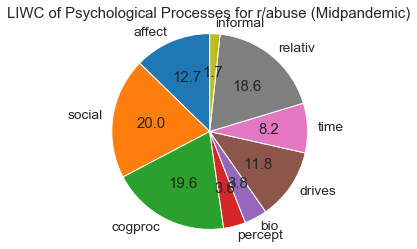

In [64]:
labels_mid = []
data_mid = []
for k in valueCount_mid:
    labels_mid.append(k)
    num = float(valueCount_mid[k])
    data_mid.append(num)
print(labels_mid)
print(data_mid)
plotter.figure(figsize=(10,10))
figureObject, axesObject = plotter.subplots()
axesObject.pie(data_mid,

        labels=labels_mid,

        autopct='%1.1f',

        startangle=90)

axesObject.axis('equal')

axesObject.set_title('LIWC of Psychological Processes for r/abuse (Midpandemic)', fontsize=15)

plotter.show()

['affect', 'social', 'cogproc', 'percept', 'bio', 'drives', 'time', 'relativ', 'informal']
[0.11196630294713958, 0.201343690055758, 0.19693065666453763, 0.03770724888440067, 0.03868716197973373, 0.11570590184311018, 0.08595318333700619, 0.1957821049579149, 0.01592374933039918]


<Figure size 720x720 with 0 Axes>

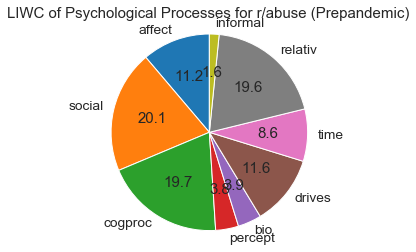

In [65]:
labels_pre = []
data_pre = []
for k in valueCount_pre:
    labels_pre.append(k)
    num = float(valueCount_pre[k])
    data_pre.append(num)
print(labels_pre)
print(data_pre)
plotter.figure(figsize=(10,10))
figureObject_pre, axesObject_pre = plotter.subplots()
axesObject_pre.pie(data_pre,

        labels=labels_pre,

        autopct='%1.1f',

        startangle=90)

axesObject_pre.axis('equal')

axesObject_pre.set_title('LIWC of Psychological Processes for r/abuse (Prepandemic)', fontsize=15)

plotter.show()

In [71]:
# top 30 most dominant features for midpandemic
count = 0
for w in sorted(valueCount_mid, key=valueCount_mid.get, reverse=True):
    if count <= 30:
        print(w, valueCount_mid[w])
        count += 1

social 0.1998456658439888
cogproc 0.1959709021450889
relativ 0.18627131632840602
affect 0.12709331596082654
drives 0.1178237489169533
time 0.08190015622128285
bio 0.037656877674797175
percept 0.03642392745556227
informal 0.017014089453094235


In [72]:
# top 30 most dominant features for prepandemic
count = 0
for w in sorted(valueCount_pre, key=valueCount_pre.get, reverse=True):
    if count <= 30:
        print(w, valueCount_pre[w])
        count += 1

social 0.201343690055758
cogproc 0.19693065666453763
relativ 0.1957821049579149
drives 0.11570590184311018
affect 0.11196630294713958
time 0.08595318333700619
bio 0.03868716197973373
percept 0.03770724888440067
informal 0.01592374933039918


In [73]:
df_mid.columns

Index(['Post ID', 'Title', 'Body', 'Author', 'Publish Date', 'No. Comments',
       'WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'Sixltr', 'Dic',
       'function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they',
       'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate',
       'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'affect',
       'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend',
       'female', 'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat',
       'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body',
       'health', 'sexual', 'ingest', 'drives', 'affiliation', 'achieve',
       'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture',
       'relativ', 'motion', 'space', 'time', 'work', 'leisure', 'home',
       'money', 'relig', 'death', 'informal', 'swear', 'netspeak', 'assent',
       'nonflu', 'filler', 'AllPunc', 'Period', 'Comma', 'Colon', 'SemiC',
       'QMark

In [76]:
df_mid['Body'] = df_mid['Body'].astype('str')
df_pre['Body'] = df_pre['Body'].astype('str')
df_ctrl['Body'] = df_ctrl['Body'].astype('str')

## Preprocessing Body Text

In [21]:
#Removing stop words
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
df_mid['subm_text_processed'] = df_mid['Body'].map(lambda x: re.sub(pattern, '', x))
df_pre['subm_text_processed'] = df_pre['Body'].map(lambda x: re.sub(pattern, '', x))
df_ctrl['subm_text_processed'] = df_ctrl['Body'].map(lambda x: re.sub(pattern, '', x))

#redditclean
df_mid['subm_text_processed'] = df_mid['subm_text_processed'].map(redditcleaner.clean)
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(redditcleaner.clean)
df_ctrl['subm_text_processed'] = df_ctrl['subm_text_processed'].map(redditcleaner.clean)

#Removing x200b
df_mid['subm_text_processed'] = df_mid['subm_text_processed'].map(lambda x: re.sub('x200b', '', x))
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('x200b', '', x))
df_ctrl['subm_text_processed'] = df_ctrl['subm_text_processed'].map(lambda x: re.sub('x200b', '', x))


#Removing url links
df_mid['subm_text_processed'] = df_mid['subm_text_processed'].map(lambda x: re.sub('(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', '', x))
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', '', x))
df_ctrl['subm_text_processed'] = df_ctrl['subm_text_processed'].map(lambda x: re.sub('(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', '', x))

#Removing ampersands
df_mid['subm_text_processed'] = df_mid['subm_text_processed'].map(lambda x: re.sub('amp', '', x))
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('amp', '', x))
df_ctrl['subm_text_processed'] = df_ctrl['subm_text_processed'].map(lambda x: re.sub('amp', '', x))

#Removing nan
df_mid['subm_text_processed'] = df_mid['subm_text_processed'].map(lambda x: re.sub('nan', '', x))
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('nan', '', x))
df_ctrl['subm_text_processed'] = df_ctrl['subm_text_processed'].map(lambda x: re.sub('nan', '', x))

#Removing new line tabs
df_mid['subm_text_processed'] = df_mid['subm_text_processed'].map(lambda x: re.sub('[\n]', '', x))
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('[\n]', '', x))
df_ctrl['subm_text_processed'] = df_ctrl['subm_text_processed'].map(lambda x: re.sub('[\n]', '', x))

# Remove punctuation
df_mid['subm_text_processed'] = df_mid['subm_text_processed'].map(lambda x: re.sub('[,\.*!?]', '', x))
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('[,\.*!?]', '', x))
df_ctrl['subm_text_processed'] = df_ctrl['subm_text_processed'].map(lambda x: re.sub('[,\.*!?]', '', x))

# Convert the titles to lowercase
df_mid['subm_text_processed'] = df_mid['subm_text_processed'].map(lambda x: x.lower())
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: x.lower())
df_ctrl['subm_text_processed'] = df_ctrl['subm_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df_mid['subm_text_processed'].head()
df_pre['subm_text_processed'].head()
df_ctrl['subm_text_processed'].head()

df_mid.head()

,Post ID,Title,Body,Author,Publish Date,No. Comments,WC,Analytic,Clout,Authentic,...,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP,subm_text_processed
0,eov93c,[Repost] [Academic] Correlates of Adversity in...,**The Program for the Study of Infancy** at **...,WallyDixon,2020-01-14 17:36:10,1,106,98.68,85.04,54.63,...,1.89,0.0,1.89,0.94,1.89,0.0,0.00,3.77,33.96,the program study infancy east tennessee state...
1,eowjab,whats the best way to get out of an abusive re...,"i’m currently unemployed, and ive dropped out ...",throwaway3839394849,2020-01-14 19:16:42,1,294,16.31,8.16,86.26,...,0.00,0.0,0.68,0.00,0.00,0.0,2.04,0.68,0.00,’currently unemployed ive dropped high school ...
2,eowsdi,A painful choice.,I had one arrow left\n\nthat I could never tak...,Mossanony,2020-01-14 19:36:51,0,108,18.82,64.46,90.03,...,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,i one arrow left i could never take back the o...
3,eoxo5m,Is this abuse?,"First off, I want to apologize if I’m overreac...",Eggs_and_Milk100,2020-01-14 20:52:46,1,159,31.56,57.49,36.10,...,0.00,0.0,1.26,0.00,0.00,0.0,3.14,1.26,0.00,first i want apologize i’overreacting my moth...
4,eoxu63,Need help describing trauma,I know this might sound weird but i am having ...,beautyandthemask,2020-01-14 21:07:49,1,249,25.61,31.50,78.35,...,0.00,0.0,0.00,0.00,0.00,0.0,2.01,1.61,0.40,i know might sound weird trouble explaining pa...


## Extracting VADER Sentiment Values

In [22]:
analyzer = SentimentIntensityAnalyzer()
sent = df_mid['subm_text_processed'].apply(analyzer.polarity_scores)
sent_pre = df_pre['subm_text_processed'].apply(analyzer.polarity_scores)
sent_ctrl = df_ctrl['subm_text_processed'].apply(analyzer.polarity_scores)
sent_df_mid = pd.DataFrame(sent.tolist())
sent_df_pre = pd.DataFrame(sent_pre.tolist())
sent_df_ctrl = pd.DataFrame(sent_ctrl.tolist())
sent_df_pre.head()

,neg,neu,pos,compound
0,0.220,0.686,0.094,-0.9817
1,0.319,0.681,0.000,-0.9213
2,0.259,0.614,0.127,-0.9944
3,0.182,0.690,0.127,-0.9218
4,0.370,0.484,0.146,-0.9924


In [23]:
df_mid = pd.concat([df_mid, sent_df_mid], axis = 1)
df_pre = pd.concat([df_pre, sent_df_pre], axis = 1)
df_ctrl = pd.concat([df_ctrl, sent_df_ctrl], axis = 1)
df_pre.head()

,Post ID,Title,Body,Author,Publish Date,No. Comments,WC,Analytic,Clout,Authentic,...,Dash,Quote,Apostro,Parenth,OtherP,subm_text_processed,neg,neu,pos,compound
0,9t93dw,Is this sibling abuse?,This happened when I was younger and I just wa...,PauljAdams,2018-11-01 05:46:50,2,403,14.55,43.09,81.16,...,0.00,0.50,1.74,0.50,0.00,this happened i younger i want clarification h...,0.220,0.686,0.094,-0.9817
1,9t9wla,dad is going to “smash my phone with a hammer”...,title. for the first time this year i was late...,DEAD2002,2018-11-01 07:30:01,4,70,68.29,28.39,97.55,...,2.86,5.71,0.00,0.00,1.43,title first time year late school - 5 minutes ...,0.319,0.681,0.000,-0.9213
2,9tcb0h,I’m terrified of my brother and can’t escape,This is my first post on reddit so sorry if my...,donutbelikethat,2018-11-01 11:54:15,5,688,14.04,47.67,69.90,...,0.00,0.29,2.62,0.00,0.44,this first post reddit sorry structure awful i...,0.259,0.614,0.127,-0.9944
3,9tj590,I have a abusive bother looking for suggestions.,This is my first ever post to reddit so sorry ...,ARetardedCanadian,2018-11-02 04:22:03,3,489,4.87,27.67,81.51,...,0.00,0.00,5.73,0.41,0.00,this first ever post reddit sorry seems weirdl...,0.182,0.690,0.127,-0.9218
4,9tk88w,My ex bf abused me over 3 years ago,I have told this before to people and been in ...,zwerrifer,2018-11-02 06:46:57,0,351,27.45,14.59,93.12,...,0.00,0.00,1.71,2.28,0.85,i told people therapy though '3 years ago i'st...,0.370,0.484,0.146,-0.9924


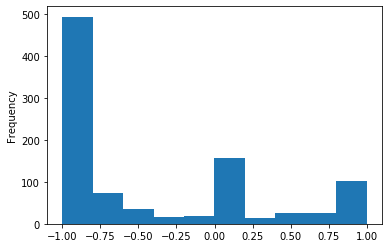

In [24]:
df_ctrl['compound'].plot(kind='hist')

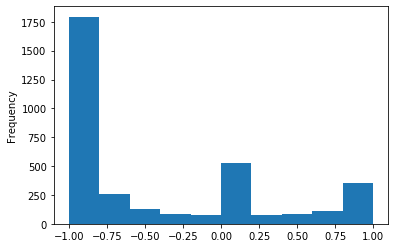

In [25]:
df_pre['compound'].plot(kind='hist')

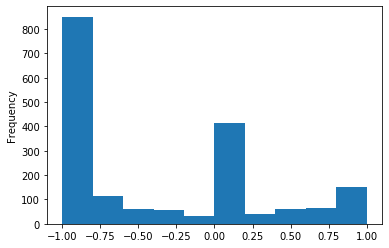

In [26]:
df_mid['compound'].plot(kind='hist')

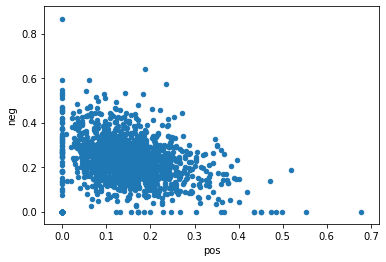

In [27]:
df_mid.plot.scatter(x='pos', y = 'neg')

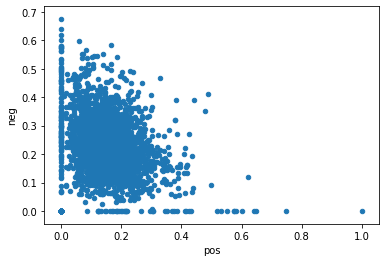

In [28]:
df_pre.plot.scatter(x='pos', y = 'neg')

### Common Words in Submissions

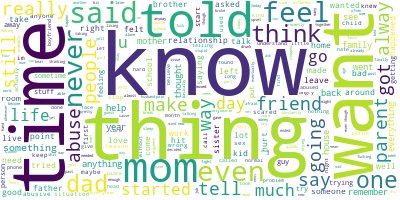

In [29]:
# Join the different processed titles together.
long_string_mid = ','.join(list(df_mid['subm_text_processed'].values))
long_string_pre = ','.join(list(df_pre['subm_text_processed'].values))
long_string_ctrl = ','.join(list(df_ctrl['subm_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string_mid)


# Visualize the word cloud
wordcloud.to_image()

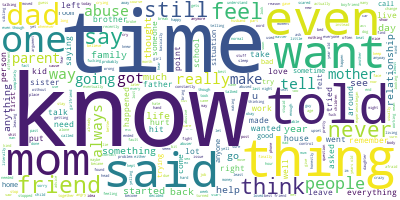

In [30]:
wordcloud.generate(long_string_pre)
wordcloud.to_image()

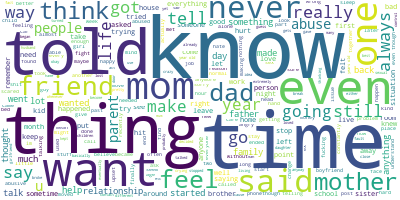

In [31]:
wordcloud.generate(long_string_ctrl)
wordcloud.to_image()

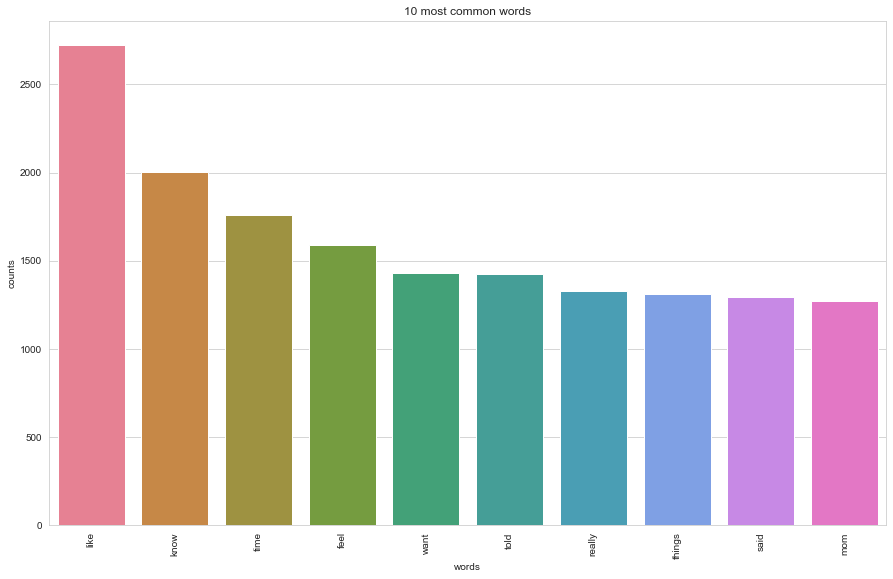

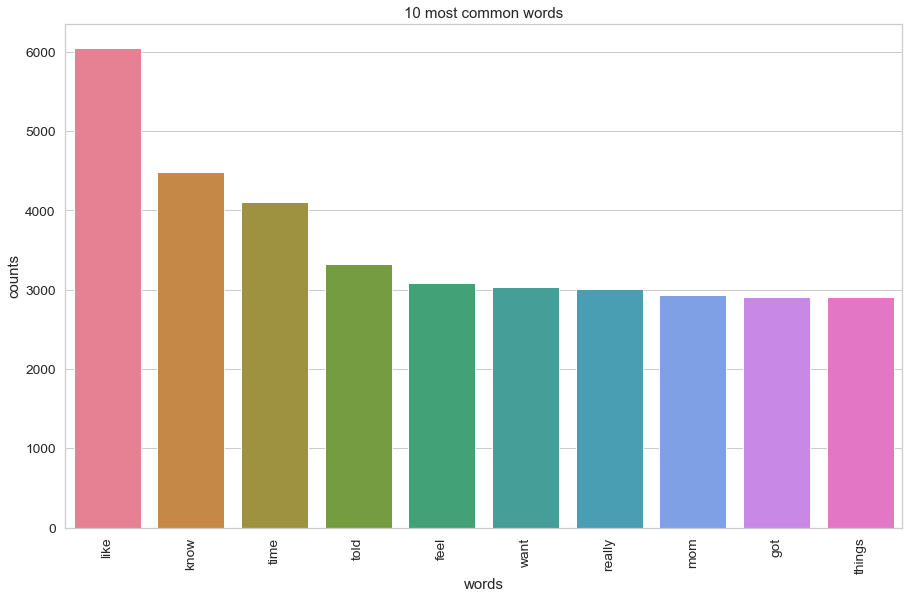

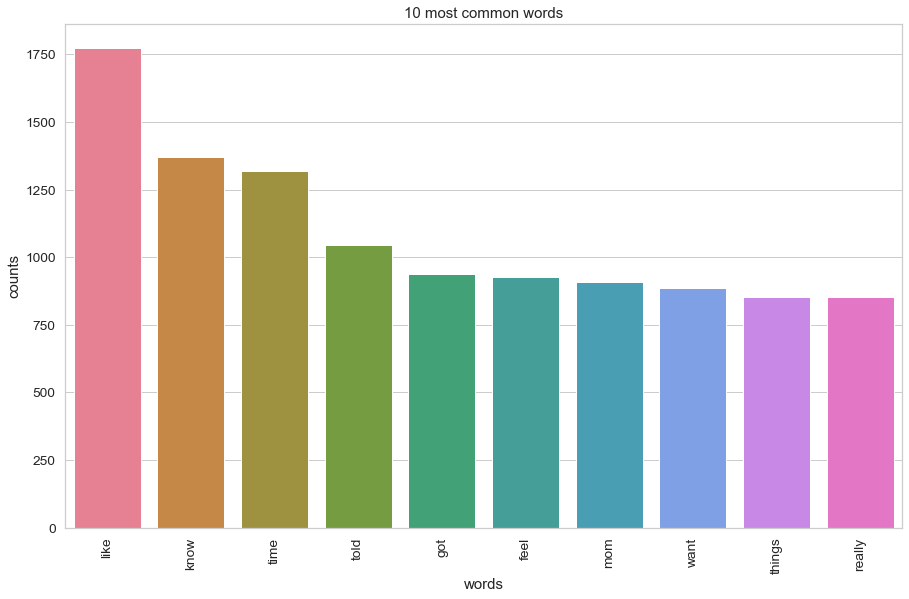

In [32]:
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialize the count vectorizer with the English stop words
count_vectorizer_mid = CountVectorizer(stop_words='english')
count_vectorizer_pre = CountVectorizer(stop_words='english')
count_vectorizer_ctrl = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data_mid = count_vectorizer_mid.fit_transform(df_mid['subm_text_processed'])
count_data_pre = count_vectorizer_pre.fit_transform(df_pre['subm_text_processed'])
count_data_ctrl = count_vectorizer_ctrl.fit_transform(df_ctrl['subm_text_processed'])


# Visualise the 10 most common words
plot_10_most_common_words(count_data_mid, count_vectorizer_mid)
plot_10_most_common_words(count_data_pre, count_vectorizer_pre)
plot_10_most_common_words(count_data_ctrl, count_vectorizer_ctrl)

## Building LDA Topic Model

### Creating the baseline model

In [35]:
stopwords = nltk.corpus.stopwords.words('english')

#filtering out frequent words that appeared multiple times in topics
top_words = ['feel', 'want', 'friend', 'time', 'abuse', 'people', 'tell', 'think', 'year', 'thing', 'leave', 'start',
            'talk', 'need', 'parent']

stopwords.extend(top_words)


# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

        
def tokenization_with_gen_stop(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)

    return result

/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [36]:
#nlp = spacy.load("en_core_web_sm")
nlp = en_core_web_sm.load()
nlp_pre = en_core_web_sm.load()

data_lemma = []
data_lemma_pre = []

for txt in tqdm(df_mid['subm_text_processed']):
    lis = []
    doc = nlp(txt)
    for token in doc:
        lis.append(token.lemma_)
    data_lemma.append(' '.join(lis))

for txt in tqdm(df_pre['subm_text_processed']):
    lis = []
    doc = nlp_pre(txt)
    for token in doc:
        lis.append(token.lemma_)
    data_lemma_pre.append(' '.join(lis))
    

data_words = []
data_words_pre = []

for txt in tqdm(data_lemma):
    data_words.append(tokenization_with_gen_stop(txt))

for txt in tqdm(data_lemma_pre):
    data_words_pre.append(tokenization_with_gen_stop(txt))

data_words_clean = []
data_words_clean_pre = []

for word in tqdm(data_words):
    wrd = []
    for w in word:
        if w not in stopwords:
            wrd.append(w)
    data_words_clean.append(wrd)

for word in tqdm(data_words_pre):
    wrd = []
    for w in word:
        if w not in stopwords:
            wrd.append(w)
    data_words_clean_pre.append(wrd)

dictionary = corpora.Dictionary(data_words_clean)
dictionary.filter_extremes(no_below=3)
corpus = [dictionary.doc2bow(text) for text in data_words_clean]

dictionary_pre = corpora.Dictionary(data_words_clean_pre)
dictionary_pre.filter_extremes(no_below=3)
corpus_pre = [dictionary_pre.doc2bow(text) for text in data_words_clean_pre]



num_topics = 10

print('------Midpandemic Topic Model-----------')

%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                 id2word=dictionary, \
                                  passes=5, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary.keys()))

for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=4):
    print(str(i)+": "+ topic)
    print()
    
%time lda_model_pre = models.LdaModel(corpus_pre, num_topics=num_topics, \
                                 id2word=dictionary_pre, \
                                  passes=5, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_pre.keys()))

print('------Prepandemic LDA Mallet Topic Model-----------')

for i,topic in lda_model_pre.show_topics(formatted=True, num_topics=num_topics, num_words=1):
    print(str(i)+": "+ topic)
    print()

100%|██████████| 3488/3488 [00:00<00:00, 3505.15it/s]


------Midpandemic Topic Model-----------
CPU times: user 28.1 s, sys: 361 ms, total: 28.5 s
Wall time: 13.4 s
0: 0.025*"like" + 0.011*"relationship" + 0.011*"family" + 0.010*"happen"

1: 0.013*"like" + 0.008*"come" + 0.008*"love" + 0.008*"house"

2: 0.027*"like" + 0.011*"room" + 0.009*"brother" + 0.009*"come"

3: 0.028*"like" + 0.013*"help" + 0.009*"happen" + 0.008*"family"

4: 0.023*"like" + 0.014*"life" + 0.008*"help" + 0.008*"relationship"

5: 0.020*"like" + 0.009*"happen" + 0.008*"abusive" + 0.008*"situation"

6: 0.014*"like" + 0.012*"happen" + 0.011*"remember" + 0.011*"come"

7: 0.028*"mother" + 0.014*"help" + 0.011*"survey" + 0.010*"adult"

8: 0.014*"like" + 0.012*"come" + 0.012*"help" + 0.007*"live"

9: 0.040*"like" + 0.009*"mother" + 0.007*"father" + 0.007*"good"

CPU times: user 26.3 s, sys: 265 ms, total: 26.5 s
Wall time: 19.4 s
------Prepandemic LDA Mallet Topic Model-----------
0: 0.012*"sister"

1: 0.040*"remember"

2: 0.014*"mother"

3: 0.011*"love"

4: 0.009*"father"

5

In [37]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_clean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
# this is the baseline LDA Model
print('\n MidPandemic Coherence Score: ', coherence_lda)


 MidPandemic Coherence Score:  0.2805064425429292


### LDA Mallet Model

### Fine tuning LDA Mallet Model to see if we can increase Coherence Score

The LDA Mallet Model results in a higher coherence score of 0.3688 when compared to the gensim package LDA Model, which resulted in a lower coherence score of 0.280 and 0.310.

By adjusting the number of topics in the LDA Mallet Model, we can calculate which model results in the higher coherence score. The coherence score increases with the increase in the number of topics. We will select the model with the highest coherence score, which is 10 topics.

In [38]:
mallet_path = "/Users/amiekong/Desktop/mallet-2.0.8/bin/mallet"

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=dictionary)

# display topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score for LDA Mallet Model Midpandemic and Prepandemic
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_clean, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('Midpandemic Coherence Score: ', coherence_ldamallet)

with open("./lda_malletModel_abuse_mid.pkl", "wb") as f:
    pickle.dump(ldamallet, f)

[(0,
  [('love', 0.06276709401709402),
   ('good', 0.04131054131054131),
   ('hate', 0.03160612535612536),
   ('life', 0.028579059829059828),
   ('hard', 0.02751068376068376),
   ('fuck', 0.022970085470085472),
   ('shit', 0.021100427350427352),
   ('lose', 0.018963675213675212),
   ('fucking', 0.01860754985754986),
   ('face', 0.01584757834757835)]),
 (1,
  [('stop', 0.03462712603576101),
   ('yell', 0.03061491495856956),
   ('angry', 0.02965547317924117),
   ('hurt', 0.026515481901439163),
   ('wrong', 0.022764936764064544),
   ('scare', 0.02250327082424771),
   ('constantly', 0.022154382904491933),
   ('upset', 0.020497165285651986),
   ('fight', 0.01761883994766681),
   ('point', 0.016921064108155255)]),
 (2,
  [('room', 0.044697633654688866),
   ('scream', 0.023504103258704487),
   ('throw', 0.021751254880089235),
   ('brother', 0.02079515576448092),
   ('door', 0.019201657238467056),
   ('head', 0.01808620827025735),
   ('hand', 0.016413034817942793),
   ('phone', 0.0155366106286

The function below converts the selected LDA Mallet model into the optimal LDA Model. We need this in order to visualize our model using pyLDAVis. 

In [41]:
%%time
import os
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

def convertldaGenToldaMallet(mallet_model):
    model_gensim = models.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(ldamallet)

#Creating Intertopic Distance Visualization
pyLDAvis.enable_notebook()

#LDAvis_data_filepath_ = os.path.join('./ldavis_prepared_mid_abuse'+str(10))

LDAvis_prepared_ = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)    
pyLDAvis.save_html(LDAvis_prepared_, './ldavis_prepared_mid_abuse.html')

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


CPU times: user 3.13 s, sys: 23.3 ms, total: 3.15 s
Wall time: 57 s


/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [40]:
LDAvis_prepared_

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.211670 -0.207430       1        1  10.845993
9     -0.293023 -0.046189       2        1  10.632920
4     -0.028483  0.115057       3        1  10.440411
2      0.124684  0.136852       4        1  10.373339
0      0.191528 -0.208129       5        1  10.138992
8      0.012367 -0.080822       6        1   9.879092
6      0.057632 -0.099015       7        1   9.792502
3      0.222774 -0.060245       8        1   9.542702
5      0.051746  0.257399       9        1   9.259062
1     -0.127555  0.192523      10        1   9.094986, topic_info=    Category        Freq      Term       Total  loglift  logprob
211  Default  781.000000  remember  781.000000  30.0000  30.0000
257  Default  783.000000      love  783.000000  29.0000  29.0000
110  Default  735.000000    mother  735.000000  28.0000  28.0000
714  Default  725.000000   brother  725.000000  27.0000  27.0000
48   Default  914.000000      life  914.000000  26.0000  26.0000
..       ...         ...       ...         ...      ...      ...
623  Topic10  103.663887   support  208.122742   1.7005  -4.7148
409  Topic10   89.015732      mess  148.900421   1.8830  -4.8671
389  Topic10   96.903206      hope  207.808655   1.6345  -4.7822
939  Topic10   86.762169     trust  176.399597   1.6879  -4.8928
210  Topic10   89.015732  recently  230.989990   1.4439  -4.8671

[847 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1076      8  0.991553  absolute
647       7  1.002221    abuser
122       3  0.170737   abusive
122       9  0.828850   abusive
2423     10  1.020606    access
...     ...       ...       ...
633       1  0.031153     young
633       5  0.070802     young
633       6  0.413484     young
633       8  0.218070     young
633       9  0.266216     young

[1094 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 5, 3, 1, 9, 7, 4, 6, 2])